In [1]:
import os 
import cv2
import numpy as np
from numpy.linalg import det, norm
from skimage import transform

import matplotlib.pyplot as plt
%matplotlib inline

# local libraries
#from utils import line_intersection
from utils import find_parallel
from utils import get_intersection_pts
from utils import compute_pairwise_angles
from utils import compute_pairwise_distances

%load_ext autoreload
%autoreload 2

In [2]:
# various constants
rad2deg = 180 / np.pi
DP1, DP2 = 0, 1  # indices, `DP' = data point
X, Y = 0, 1

# global figure properties
save_figures = False
#figsize = (10, 6)
figsize = (8, 4)
s = 75

In [3]:
path = '/scratch/ssd/cciw/sample_data/'
images = os.listdir(path)

#file = '1340_2016-07-11_1_GLN_3447.JPG' # 5/5 (3776, 6720, 3)
file = '1340_2016-07-11_2_GLN_3450.JPG' # 4/5 (4912, 7360, 3)
#file = '1340_2016-07-11_3_GLN_3452.JPG' # 5/5 (4912, 7360, 3)
#file = '1349_2016-07-06_2_GLN_3061.JPG'  # 3/5, step 3 lines are offset, probably because portrait vs. landscape mode
#file = '1342_2016-07-07_2_GLN_3182.JPG'
#file = 'GLNI_456-1_2016-07-20_image-2.jpg' # (4924, 7378, 3)
outpath = file.split('.')[0]

In [4]:
f = os.path.join(path, file)
im = cv2.imread(f)
im.shape  # (height, width)

(4912, 7360, 3)

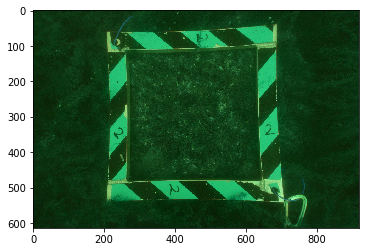

In [5]:
ds = 8  # naive downsampling by factor of 8
plt.figure(figsize=figsize)
plt.imshow(im[::ds, ::ds])

0 -0.00
0 (-920, 532) (919, 533)


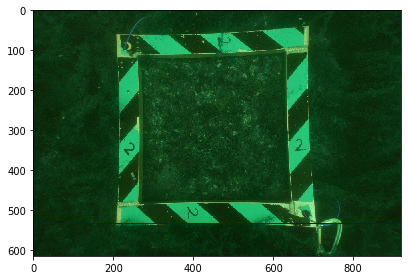

In [6]:
'''
@param threshold Accumulator threshold parameter. Only those lines are returned that get enough
       votes ( \f$>\texttt{threshold}\f$ ).
@param minLineLength Minimum line length. Line segments shorter than that are rejected.
@param maxLineGap Maximum allowed gap between points on the same line to link them.
'''
img = np.ascontiguousarray(im[::ds, ::ds], dtype=np.uint8)
img_h = img.shape[0]
img_w = img.shape[1]
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

edges = cv2.Canny(gray, 20, 400, L2gradient=True) # GLN_3447

# @param rho Distance resolution of the accumulator in pixels.
rho = 1  
# @param theta Angle resolution of the accumulator in radians.
theta = np.pi / 90  # note, with 180 getting too many overlapping lines.

lines  =  cv2.HoughLines(edges, rho, theta, threshold=100)
N = 1
coords = np.zeros((N, 2, 2)).astype('int') # points, start/end, x/y
angles = np.zeros(N)
for i in range(len(lines[:N])):
    for r, theta in lines[i]:
        # theta is normal to the line wrt x-axis, so we subtract 90
        if r > 0:
            angles[i] = 90 - theta * 180 / np.pi
        else: 
            angles[i] = 270 - theta * 180 / np.pi
        print(i, '%.2f' % angles[i])
        a = np.cos(theta)
        b = np.sin(theta)
        x0, y0 = a * r, b * r
        x1 = int(x0 + img_w * -b)
        y1 = int(y0 + img_w *  a)
        x2 = int(x0 - img_w * -b)
        y2 = int(y0 - img_w *  a)
        #coords.append([[x1, y1], [x2, y2]])
        coords[i, DP1, X] = x1
        coords[i, DP1, Y] = y1
        coords[i, DP2, X] = x2
        coords[i, DP2, Y] = y2
        print(i, (x1, y1), (x2, y2))
        cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)  # 2 is the line width
plt.figure(figsize=figsize)
plt.imshow(img)
#plt.xlabel('x')
#plt.ylabel('y')
plt.tight_layout()
if save_figures:
    plt.savefig('img/' + outpath + '-Step-1.png')
plt.show()

## Probabilistic HoughLines

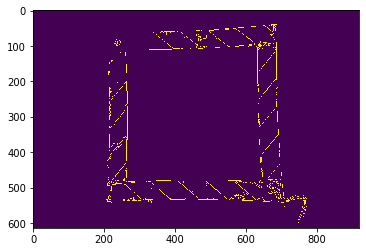

In [7]:
plt.imshow(edges)

Found 20 lines


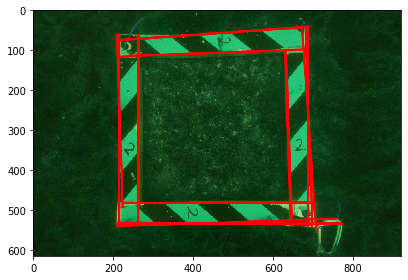

In [8]:
img = np.ascontiguousarray(im[::ds, ::ds], dtype=np.uint8)
img_h = img.shape[0]
img_w = img.shape[1]
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# @param canny_threshold1 Histeresis threshold 1
# @param canny_threshold2
canny_thresh1 = 40
canny_thresh2 = 400

# run the Canny edge detector on the rotated gray scale image
edges = cv2.Canny(gray, threshold1=canny_thresh1, threshold2=canny_thresh2, L2gradient=False) # GLN_3447

# @param rho Distance resolution of the accumulator (pixels).
rho = 1  

# @param theta Angle resolution of the accumulator (radians).
theta = np.pi / 90

# @param threshold Accumulator threshold, return lines with more than threshold of votes. (intersection points)
threshold = 100

# @param minLineLength Minimum line length. Line segments shorter than that are rejected. (pixels)
mLL = 300

# @param maxLineGap Maximum allowed gap between points on the same line to link them. (pixels)
mLG = 100
#mLG = 200 # increased to 200 for GLNI_456-1_2016-07-20_image-2.jpg

# run the probabilistic hough lines transform
linesP = cv2.HoughLinesP(edges, rho, theta, threshold=threshold, minLineLength=mLL, maxLineGap=mLG)

# @param lines The extremes of the detected lines if any (<N_LINES_FOUND>, 1, x_0, y_0, x_1, y_1). (pixels)
print('Found %d lines' % len(linesP))

N = 100  # top N results to draw
if linesP is not None:
    for i in range(len(linesP[:N])):
        l = linesP[i][0]
        pt1 = (l[0], l[1])
        pt2 = (l[2], l[3])
        rgb = (255, 0, 0)
        line_width = 3
        cv2.line(img, pt1, pt2, rgb, line_width, cv2.LINE_AA)
plt.figure(figsize=figsize)
plt.imshow(img)
#plt.xlabel('x')
#plt.ylabel('y')
plt.tight_layout()
if save_figures:
    plt.savefig('img/' + outpath + '-Step-2.png')
plt.show()

In [9]:
# line below origin, rho positive, angle less than 180
# line above origin, rho negative, angle less than 180
#lines = cv2.HoughLines(edges, rho, theta, threshold=100)

if lines[0, 0, 1] > 0:
    if lines[0, 0, 0] > 0 or lines[0, 0, 1] < np.pi / 2:
        print('rho positive, or theta < 90')
        rot_deg = 90 - lines[0, 0, 1] * rad2deg
    else:
        print('rho negative')
        rot_deg = 90 - lines[0, 0, 1] * rad2deg
        #rot_deg = 180 - lines[0, 0, 1] * rad2deg
else:
    rot_deg = 0
t = rot_deg / rad2deg
print(t)

rho positive, or theta < 90
-4.371138995127344e-08


In [10]:
#linesP_ls = linesP.squeeze().tolist()

In [209]:
coordsP = np.zeros((np.minimum(N, len(linesP)), 2, 2)).astype('int') # points, start/end, x/y
for i in range(len(linesP[:N])):
    l = linesP[i][0]
    coordsP[i, DP1, X] = l[0] # x1
    coordsP[i, DP1, Y] = l[1] # y1
    coordsP[i, DP2, X] = l[2] # x2
    coordsP[i, DP2, Y] = l[3] # y2    
R = np.array([[np.cos(-t), -np.sin(-t)],
              [np.sin(-t),  np.cos(-t)]])
coords = np.dot(coordsP, R)
correction_factor = coordsP[0, DP1, Y] - coords[0, DP1, Y]
for i in range(len(linesP[:N])):
    coords[i, DP1, Y] += correction_factor
    coords[i, DP2, Y] += correction_factor

In [210]:
#angles = compute_pairwise_angles(coordsP)

In [244]:
#plt.figure(figsize=(12, 10))
center = (coordsP[0, DP1, X], coordsP[0, DP1, Y])
imgr = transform.rotate(
    np.ascontiguousarray(
        im[::ds, ::ds], dtype=np.uint8
    ), -rot_deg, center=center, resize=False)
imgr = (255 * imgr).astype(np.uint8)
clean_img = imgr.copy()
#plt.imshow(imgr[:, :])
#plt.show()
#for i in lines_to_merge[7]:
'''
cv2.line(imgr, (int(coords[i, DP1, X]), int(coords[i, DP1, Y])),
                   (int(coords[i, DP2, X]), int(coords[i, DP2, Y])),
             (255, 0, 0), 3, cv2.LINE_AA)         
plt.imshow(imgr)
'''

'\ncv2.line(imgr, (int(coords[i, DP1, X]), int(coords[i, DP1, Y])),\n                   (int(coords[i, DP2, X]), int(coords[i, DP2, Y])),\n             (255, 0, 0), 3, cv2.LINE_AA)         \nplt.imshow(imgr)\n'

In [245]:
#l2m[2]

In [246]:
#index = 8
#for i in l2m[index]:
for i in range(len(coords)):
    cv2.line(imgr, 
             (int(coords[i, DP1, X]), int(coords[i, DP1, Y])),
             (int(coords[i, DP2, X]), int(coords[i, DP2, Y])),
             (255, 0, 0), 3, cv2.LINE_AA)
#plt.figure(figsize=figsize)
plt.imshow(imgr)
plt.tight_layout()
#if save_figures:
#plt.savefig('img/' + outpath + '-Step-l2m[%d].png' % index)

OverflowError: signed integer is greater than maximum

In [249]:
#coords

array([[[672.00000179,  41.        ],
        [707.00002395, 547.99999847]],

       [[207.0000233 , 533.00002033],
        [772.0000233 , 532.99999563]],

       [[389.00002094, 479.00001237],
        [694.00002094, 478.99999904]],

       [[263.00002347, 537.00001788],
        [263.00000267,  61.00001788]],

       [[215.00002365, 541.00001998],
        [215.00000267,  61.00001998]],

       [[207.00002325, 532.00002033],
        [771.00002325, 531.99999567]],

       [[222.00002103, 481.00001967],
        [699.00002103, 480.99999882]],

       [[629.00000428,  98.00000188],
        [644.00002352, 538.00000122]],

       [[687.00002365, 540.99999934],
        [687.00000175,  39.99999934]],

       [[211.00000507, 116.00002015],
        [633.00000441, 101.0000017 ]],

       [[632.00000433,  99.00000175],
        [647.00002352, 538.00000109]],

       [[208.00002321, 531.00002028],
        [771.00002321, 530.99999567]],

       [[633.00000634, 145.0000017 ],
        [646.00002352, 538

In [204]:
# Check angle between lines

In [215]:
angles = compute_pairwise_angles(coords)
print(len(angles))

190


In [216]:
values, counts = np.unique(angles[:, 2], return_counts=True)
print(values)
print(counts)

[  0   1   2   4  85  86  87  88  89  90  92 176 178]
[30 10 16 10  8  5  8 32  1 36 10  4 20]


In [217]:
#np.allclose?

In [218]:
TOLERANCE = 4  # Max deviation

In [219]:
greater_180_mask = angles[:, 2] > 180 + TOLERANCE
less_180_mask = angles[:, 2] < 180 - TOLERANCE
greater_90_mask = angles[:, 2] > 90 + TOLERANCE
less_90_mask = angles[:, 2] < 90 - TOLERANCE
greater_tol_mask = angles[:, 2] > TOLERANCE
outlier_angle_mask  = greater_180_mask
outlier_angle_mask |= (less_180_mask & greater_90_mask)
outlier_angle_mask |= (less_90_mask & greater_tol_mask)

In [220]:
print(angles[outlier_angle_mask])
print(len(angles[outlier_angle_mask]))
# 1. lines get more points according to how many inlier angles they contribute to
# 2. prefer lines with lower index in case of a tie because they have more hough votes

[[ 3  5 85]
 [ 3  7 85]
 [ 4  5 85]
 [ 4  7 85]
 [ 5 10 85]
 [ 5 19 85]
 [ 7 10 85]
 [ 7 19 85]]
8


In [221]:
candidate_outlier_line_idx, cts = np.unique(
    angles[outlier_angle_mask, :2], return_counts=True)
print(candidate_outlier_line_idx)
print(cts)

[ 3  4  5  7 10 19]
[2 2 4 4 2 2]


In [222]:
outlier_line_idx = candidate_outlier_line_idx[cts > cts.min()]
n_inliers = len(coords) - len(outlier_line_idx)
n_inliers

18

In [223]:
coord_list = coords.tolist()
# pop with an offset because the list shrinks after each pop
for offset, idx in enumerate(outlier_line_idx):
    print(coord_list.pop(idx - offset))

[[209.00000332206542, 76.00002023837351], [689.0000018358777, 41.99999925690637]]
[[209.00000327835406, 75.00002023837351], [689.0000017921664, 40.99999925690637]]


In [224]:
coords = np.asarray(coord_list)
print(len(coords))
angles = compute_pairwise_angles(coords)
print(len(angles))

18
153


In [225]:
parallel_mask  = angles[:, 2] < TOLERANCE
greater_180_mask = angles[:, 2] > 180 - TOLERANCE
less_180_mask = angles[:, 2] < 180 + TOLERANCE
parallel_mask |= ( greater_180_mask & less_180_mask)
len(angles[parallel_mask])
#print(angles[parallel_mask])

69

In [226]:
coords_bak = coords.copy()
print(len(coords_bak))

18


In [248]:
coords = coords_bak.copy()
print(len(coords))

18


In [238]:
l2m = []  # lines to merge
TOL = 5
CUR_LINE_IDX = 0
OTHER_LINE_IDX = 1
ANGLE_IDX = 2

n_lines_orig = len(coords)
# find candidate lines to be merged
for i in range(n_lines_orig):
    # get angle of all lines wrt current line i
    cur_angles = angles[angles[:, CUR_LINE_IDX] == i]
    # find all lines that are parallel to line i
    par_angles = cur_angles[find_parallel(cur_angles[:, ANGLE_IDX], TOL)]
    # compare endpoints
    par_lines = par_angles[:, OTHER_LINE_IDX] # other line indices
    # distance between endpoints
    pointwise_dist = norm(np.minimum(
        np.maximum(coords[i, DP1] - coords[par_lines, DP1], 
                   coords[i, DP1] - coords[par_lines, DP2]), 
        np.maximum(coords[i, DP2] - coords[par_lines, DP1], 
                   coords[i, DP2] - coords[par_lines, DP2])), axis=1)
    # parallel lines with close endpoints can be merged with line i
    to_merge_idx = par_lines[pointwise_dist < 20]
    
    for item in to_merge_idx:
        l2m.append(item)

    a = coords[[i] + to_merge_idx.tolist()].copy()
    # ToDo: fix this part!
    #a.sort(axis=1)
    
    """We sort by the higher variance dimension so that the 
    compatible values end up in the same place (either in the 
    data point 1 (DP1) or DP2 position). Since we already checked 
    that the lines are parallel, we know the other dimension 
    (X or Y) is of low variance. For example, we want
    
    [[687 540]        [[687 38]
     [687  38]]        [687  540]]
                 ==> 
    [[681  39]        [[681  39]
     [698 541]]]       [698 541]]]
     
    so that for the merged line, we average 38 with 39, 
    and not 540 with 39. For cmd below refer to docs
    - https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.view.html
    - https://stackoverflow.com/questions/2828059/sorting-arrays-in-numpy-by-column/30623882
    """
    if np.var(a[:, :, X]) < np.var(a[:, :, Y]):
        # 'i8' means 8-byte integer, order is col for sorting with respect to
        a = np.sort(a.view('i8, i8'), order=['f1'], axis=1).view(np.int)
    else:
        a = np.sort(a.view('i8, i8'), order=['f0'], axis=1).view(np.int)
        
    coords[i] = np.array([[a[:, DP1, X].mean(), a[:, DP1, Y].mean()],
                          [a[:, DP2, X].mean(), a[:, DP2, Y].mean()]]) 

# remove redundant lines    
coord_list = coords.tolist()
# get the unique indices in lines-to-merge, then back to list
l2m = np.unique(np.asarray(l2m)).tolist()
for idx in sorted(l2m, reverse=True):
    popped = coord_list.pop(idx)
    print(idx, popped)
coords = np.asarray(coord_list)
assert len(coords) == n_lines_orig - len(l2m)

17 [[4.643351953355013e+18, 4.633922544097477e+18], [4.64335195368875e+18, 4.647433340783385e+18]]
15 [[4.641557550424622e+18, 4.633781806947472e+18], [4.642085316668814e+18, 4.647362972069966e+18]]
14 [[4.649201355182484e+18, 4.630826316788346e+18], [4.649350888956492e+18, 4.647969902134e+18]]
13 [[4.641522366787677e+18, 4.647952310136355e+18], [4.64987865452975e+18, 4.647785184157464e+18]]
11 [[4.641522366781525e+18, 4.647917125764266e+18], [4.649935829136509e+18, 4.647833562666586e+18]]
10 [[4.648770346647081e+18, 4.636666922733495e+18], [4.648902288211205e+18, 4.647943513874542e+18]]
8 [[4.649227743461551e+18, 4.63082631676989e+18], [4.64930251044487e+18, 4.647969902136114e+18]]
5 [[4.641510638655958e+18, 4.647908329671372e+18], [4.649954887338889e+18, 4.647852620867301e+18]]


In [199]:
idx = [i] + to_merge_idx.tolist() 
a = coords[idx].astype('int')  # (3, 2, 2)
#a[0, DP1, X] = 800
#a[1, DP1, X] = 540
print(a)

[[[672  41]
  [707 547]]

 [[687 540]
  [687  39]]

 [[681  39]
  [698 540]]]


In [198]:
# see https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.view.html
# and https://stackoverflow.com/questions/2828059/sorting-arrays-in-numpy-by-column/30623882
# 'i8' means 8-byte integer, order and axis are col and axis for sorting along
np.sort(a.view('i8, i8'), order=['f0'], axis=1).view(np.int)

array([[[707, 547],
        [800,  41]],

       [[540, 540],
        [687,  39]],

       [[681,  39],
        [698, 540]]])

In [197]:
np.sort(a.view('i8, i8'), order=['f1'], axis=1).view(np.int)

array([[[800,  41],
        [707, 547]],

       [[687,  39],
        [540, 540]],

       [[681,  39],
        [698, 540]]])

# Find Intersection Points

In [ ]:
corners_np = get_intersection_pts(coords, img_w, img_h)
print(len(corners_np))

In [ ]:
from utils import centroid_and_crop_pts

In [ ]:
fig = plt.figure(figsize=figsize)
ax2 = fig.gca()
centroid, crop = centroid_and_crop_pts(corners_np)
for i in range(len(corners_np)):
    ax2.scatter(corners_np[i, 0], corners_np[i, 1], c='b', s=s)
    ax2.annotate(i, xy=(corners_np[i, 0] + 1, corners_np[i, 1] + 1), 
                 c='white', fontsize=18)
ax2.scatter(centroid[0], centroid[1], c='white', s=s)
ax2.scatter(crop[:, 0], crop[:, 1], c='pink')
ax2.imshow(imgr)
ax2.axis('off')
plt.tight_layout()
#plt.savefig('img/' + outpath + '-Step-4-noisy-corners.png')

In [ ]:
# check crop points are equidistant
crop_dist_centroid = norm(crop - centroid, axis=1)
print(crop_dist_centroid.var())
print(crop_dist_centroid)

In [ ]:
crop_distances = compute_pairwise_distances(crop)

In [ ]:
#corners_np

In [ ]:
len(corner_distances_np)

In [ ]:
plt.hist(corner_distances_np[:, 2], bins=50)

In [ ]:
corner_distances_np = compute_pairwise_distances(corners_np)
distances = corner_distances_np[:, 2]
#print(distances)
values, counts = np.unique(distances, return_counts=True)
print(values)
print(counts)

In [ ]:
#plt.hist(counts)

In [ ]:
crop_distances

In [ ]:
cond1 = crop_dist_centroid.var() > 10
cond2 = (crop_distances[:, 2] < 200).sum() > 1
#print(cond1)
#print(cond2)

#if cond2:
    
# Filter corner points that have too small pairwise distance
corner_distances_np = compute_pairwise_distances(corners_np)
distances = corner_distances_np[:, 2]
#disc_data = np.digitize(distances, bins=np.linspace(min(distances), max(distances), 75))
values, counts = np.unique(distances, return_counts=True)
#print(values)
print(counts)

small_mask = distances < values[np.argsort(counts)[-3]]

small_dist = corner_distances_np[small_mask]

sm_values, sm_counts = np.unique(small_dist[:, :2], return_counts=True)
#print(values)  # corners implicated 
#print(counts)
outliers = sm_values[sm_counts > 1]
print(outliers)

# filter points that are part of lines that are too small
#for out in outliers:
#    corners_np[out] = -1

In [ ]:
plt.hist(distances, bins=50)

In [ ]:
bins = np.linspace(min(distances), max(distances), 75)
disc_data = np.digitize(distances, bins=bins)
values, counts = np.unique(disc_data, return_counts=True)

print(values)
print(counts)

In [ ]:
values

In [ ]:
counts

In [ ]:
#distances < 442

In [ ]:
corner_dis

In [ ]:
# any points contributing to long line segments are considered inliers
nb_terms = (counts > 2).sum()
    long_mask = distances == values[np.argsort(counts)[-1]]
    print(long_mask.sum())

    for i in range(2, nb_terms):
        long_mask |= distances == values[np.argsort(counts)[-i]]
        print(i, long_mask.sum())

    inliers = np.unique(corner_distances_np[long_mask][:, :2])
    print(inliers)

In [ ]:
        
    # filer points that aren't contributing to a long segment
    for i in range(len(corners_np)):
        if i not in inliers:
            corners_np[i] = -1
    corners_clean_np = corners_np[corners_np > -1]
    corners_clean_np = corners_clean_np.reshape(-1, 2)
    
    centroid = corners_clean_np.mean(axis=0, keepdims=True)[0]
    corner_dist = np.linalg.norm(corners_clean_np - centroid, axis=1)
    indices = np.argsort(corner_dist)
    crop = corners_clean_np[indices][:4].astype('int')

    # check crop points are equidistant
    crop_dist_centroid = np.linalg.norm(crop - centroid, axis=1)

In [ ]:
"""
Note that 10 is an arbitrary threshold on the variance 
of the distances of the crop points to the centroid.
The consequence of incorrectly choosing this value 
is minor as the crop area will be estimated from the 
best 2 of 4 points. If we already have the correct
4 interior points, we can skip this error check.
"""
#if crop_dist_centroid.var() > 10:
if True:
    crop_distances = compute_pairwise_distances(crop)

    cts = np.zeros(len(crop))
    thresh = np.median(crop_distances[:, 2])
    for i in range(len(crop_distances)):
        if crop_distances[i, 2] > thresh:
            cts[crop_distances[i, 0]] += 1
            cts[crop_distances[i, 1]] += 1
    ref_point = np.argmax(cts)

    # the second reference point is the one with min dist to the ref_point
    best = 1000
    for i in range(len(crop)):
        if i != ref_point:
            dist_to_ref = int(np.linalg.norm(crop[ref_point] - crop[i]))
            #print(i, dist_to_ref)
            if dist_to_ref < best:
                best = dist_to_ref
                best_idx = i
    #print(best_idx)
    print(crop[ref_point])
    print(crop[best_idx])
    
    start_x = np.minimum(crop[best_idx, 0], crop[ref_point, 0])
    end_x   = np.maximum(crop[best_idx, 0], crop[ref_point, 0])
    delta_x = end_x - start_x

    start_y = np.minimum(crop[best_idx, 1], crop[ref_point, 1])
    end_y   = np.maximum(crop[best_idx, 1], crop[ref_point, 1])
    delta_y = end_y - start_y

    if delta_x > delta_y:
        end_y  = int(np.maximum(end_y, delta_x)) + start_y
    else:
        end_x  = int(np.maximum(end_x, delta_y)) + start_x

# else use the existing points
else:
    print("Using existing crop pts")
    #crop.sort(0)
    buffer = 10
    start_x = crop[:, 0].min() + buffer # crop[ 0, 0]
    end_x   = crop[:, 0].max() - buffer # crop[-2, 0]
    start_y = crop[:, 1].min() + buffer # crop[ 1, 1]
    end_y   = crop[:, 1].max() - buffer # crop[ 2, 1]

In [ ]:
start_x

In [ ]:
end_x

In [ ]:
fig = plt.figure(figsize=figsize)
ax2 = fig.gca()
for i in range(len(corners_np)):
    #if i not in outliers:
    ax2.scatter(corners_np[i, 0], corners_np[i, 1], c='b', s=s)
    ax2.annotate(i, xy=(corners_np[i, 0] + 1, corners_np[i, 1] + 1), 
                 c='white', fontsize=18)
ax2.scatter(centroid[0], centroid[1], c='white', s=s)
ax2.scatter(crop[:, 0], crop[:, 1], c='pink')
ax2.scatter(start_x, start_y, c='y', s=s)
ax2.scatter(end_x,   end_y, c='y', s=s)
ax2.imshow(imgr)
plt.tight_layout()
if save_figures:
    plt.savefig('img/' + outpath + '-Step-4-clean-corners.png')

In [ ]:
buffer = 10
plt.figure(figsize=(6, 6))
cropped_img = clean_img[start_y:end_y, start_x:end_x, :]
plt.imshow(cropped_img)
plt.tight_layout()
if save_figures:
    plt.savefig('img/' + outpath + '-Step-5.png')